In [1]:
import pandas as pd
import requests
import os
from threading import Thread
from  torchvision import transforms, datasets
from torch.utils.data import DataLoader
from torchvision.models import resnet50, ResNet50_Weights
from torchinfo import summary
import torch
from torch import nn
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import random
from PIL import Image
from pathlib import Path
from sklearn.metrics import classification_report
import numpy as np

c:\Users\pc\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [33]:
df = pd.read_csv("../data/US_youtube_trending_data.csv")
df.head()

,video_id,title,publishedAt,channelId,channelTitle,categoryId,trending_date,tags,view_count,likes,dislikes,comment_count,thumbnail_link,comments_disabled,ratings_disabled,description
0,3C66w5Z0ixs,I ASKED HER TO BE MY GIRLFRIEND...,2020-08-11T19:20:14Z,UCvtRTOMP2TqYqu51xNrqAzg,Brawadis,22,2020-08-12T00:00:00Z,brawadis|prank|basketball|skits|ghost|funny vi...,1514614,156908,5855,35313,https://i.ytimg.com/vi/3C66w5Z0ixs/default.jpg,False,False,SUBSCRIBE to BRAWADIS ▶ http://bit.ly/Subscrib...
1,M9Pmf9AB4Mo,Apex Legends | Stories from the Outlands – “Th...,2020-08-11T17:00:10Z,UC0ZV6M2THA81QT9hrVWJG3A,Apex Legends,20,2020-08-12T00:00:00Z,Apex Legends|Apex Legends characters|new Apex ...,2381688,146739,2794,16549,https://i.ytimg.com/vi/M9Pmf9AB4Mo/default.jpg,False,False,"While running her own modding shop, Ramya Pare..."
2,J78aPJ3VyNs,I left youtube for a month and THIS is what ha...,2020-08-11T16:34:06Z,UCYzPXprvl5Y-Sf0g4vX-m6g,jacksepticeye,24,2020-08-12T00:00:00Z,jacksepticeye|funny|funny meme|memes|jacksepti...,2038853,353787,2628,40221,https://i.ytimg.com/vi/J78aPJ3VyNs/default.jpg,False,False,I left youtube for a month and this is what ha...
3,kXLn3HkpjaA,XXL 2020 Freshman Class Revealed - Official An...,2020-08-11T16:38:55Z,UCbg_UMjlHJg_19SZckaKajg,XXL,10,2020-08-12T00:00:00Z,xxl freshman|xxl freshmen|2020 xxl freshman|20...,496771,23251,1856,7647,https://i.ytimg.com/vi/kXLn3HkpjaA/default.jpg,False,False,Subscribe to XXL → http://bit.ly/subscribe-xxl...
4,VIUo6yapDbc,Ultimate DIY Home Movie Theater for The LaBran...,2020-08-11T15:10:05Z,UCDVPcEbVLQgLZX0Rt6jo34A,Mr. Kate,26,2020-08-12T00:00:00Z,The LaBrant Family|DIY|Interior Design|Makeove...,1123889,45802,964,2196,https://i.ytimg.com/vi/VIUo6yapDbc/default.jpg,False,False,Transforming The LaBrant Family's empty white ...


In [34]:
likes_mean = df['likes'].mean()
df["likes"] = df["likes"].replace(0,likes_mean)

In [35]:
view_count_mean = df['view_count'].mean()
df["view_count"] = df["view_count"].replace(0,view_count_mean)

In [36]:
df.drop_duplicates(subset=['thumbnail_link', 'video_id'], keep='last', inplace=True)
df.shape[0]

44009

In [37]:
def categorize_image(row):
    likes_to_view_percent = row['likes'] * 100 / row['view_count']
    if likes_to_view_percent < 2:
        return 'unpopular'
    
    if likes_to_view_percent >= 2 and likes_to_view_percent < 5:
        return 'semi-popular'
    
    if likes_to_view_percent >= 5 and likes_to_view_percent < 10:
        return 'popular'
    
    if likes_to_view_percent >= 10:
        return 'very-popular'

In [38]:
df['image_category'] = df.apply(categorize_image, axis=1)
df.head()

,video_id,title,publishedAt,channelId,channelTitle,categoryId,trending_date,tags,view_count,likes,dislikes,comment_count,thumbnail_link,comments_disabled,ratings_disabled,description,image_category
172,cAtazIk1IYw,How To Make a Curried Egg Sandwich,2020-08-07T18:30:06Z,UCR4s1DE9J4DHzZYXMltSMAg,HowToBasic,26,2020-08-12T00:00:00Z,how to make a curried egg sandwich|curried egg...,1238677.0,104736.0,3736,13876,https://i.ytimg.com/vi/cAtazIk1IYw/default.jpg,False,False,Today I show you how to make a curried egg san...,popular
173,NYFHnIiA8gE,Cake Rescue Fixing Viral Cake Fails | How To C...,2020-08-07T09:30:04Z,UCsP7Bpw36J666Fct5M8u-ZA,How To Cook That,24,2020-08-12T00:00:00Z,cake rescue|caek fail|viral cake fails|funny c...,938198.0,44088.0,565,2409,https://i.ytimg.com/vi/NYFHnIiA8gE/default.jpg,False,False,"Cake Rescue: viral cake fails, how to rescue ...",semi-popular
174,czwejgoH3zs,"Son, lemme teach you something new",2020-08-06T19:47:12Z,UCw03U5DZGLqvv5elJvXvR0Q,Bread Boys,24,2020-08-12T00:00:00Z,[None],1722152.0,169501.0,927,7263,https://i.ytimg.com/vi/czwejgoH3zs/default.jpg,False,False,badum tss *funny haha noises*YOU CAN FIND US H...,popular
175,dO6YihaqtaQ,Trump takes executive action to address econom...,2020-08-09T01:35:42Z,UCBi2mrWuNuyYy4gbM6fU18Q,ABC News,25,2020-08-12T00:00:00Z,president|trump|donald|executive|orders|stimul...,1090847.0,10922.0,2517,9876,https://i.ytimg.com/vi/dO6YihaqtaQ/default.jpg,False,False,The president’s order includes unemployment re...,unpopular
176,sSjtGqRXQ9Y,JUDAS AND THE BLACK MESSIAH - Official Trailer,2020-08-06T23:01:42Z,UCjmJDM5pRKbUlVIzDYYWb6g,Warner Bros. Pictures,24,2020-08-12T00:00:00Z,warner bros|warner brothers|wb|fred hampton|wi...,971704.0,23311.0,1987,3240,https://i.ytimg.com/vi/sSjtGqRXQ9Y/default.jpg,False,False,Watch the trailer for Judas and the Black Mess...,semi-popular


In [39]:
print('unpopular: ' + str(df[df['image_category'] == 'unpopular'].shape[0]))
print('semi-popular: ' + str(df[df['image_category'] == 'semi-popular'].shape[0]))
print('popular: ' + str(df[df['image_category'] == 'popular'].shape[0]))
print('very-popular: ' + str(df[df['image_category'] == 'very-popular'].shape[0]))

unpopular: 9102
semi-popular: 17006
popular: 14712
very-popular: 3189


In [40]:
columns_to_delete = ['title', 'channelId', 'channelTitle', 'tags', 'comments_disabled', 'ratings_disabled', 'description', 'publishedAt', 'trending_date', 'categoryId', 'view_count', 'likes', 'dislikes', 'comment_count']

for column in columns_to_delete : 
    df.drop(column, axis='columns', inplace=True)
    
df.head()

,video_id,thumbnail_link,image_category
172,cAtazIk1IYw,https://i.ytimg.com/vi/cAtazIk1IYw/default.jpg,popular
173,NYFHnIiA8gE,https://i.ytimg.com/vi/NYFHnIiA8gE/default.jpg,semi-popular
174,czwejgoH3zs,https://i.ytimg.com/vi/czwejgoH3zs/default.jpg,popular
175,dO6YihaqtaQ,https://i.ytimg.com/vi/dO6YihaqtaQ/default.jpg,unpopular
176,sSjtGqRXQ9Y,https://i.ytimg.com/vi/sSjtGqRXQ9Y/default.jpg,semi-popular


In [41]:
if not os.path.exists('../data/images'):
    os.mkdir('../data/images')
    os.mkdir('../data/images/train')
    os.mkdir('../data/images/test')
    os.mkdir('../data/images/train/unpopular')
    os.mkdir('../data/images/train/semi-popular')
    os.mkdir('../data/images/train/popular')
    os.mkdir('../data/images/train/very-popular')
    os.mkdir('../data/images/test/unpopular')
    os.mkdir('../data/images/test/semi-popular')
    os.mkdir('../data/images/test/popular')
    os.mkdir('../data/images/test/very-popular')
    
    default_image_link = str(df[df['video_id'] == '_4_mAt4nexs'].iloc[0]['thumbnail_link'])
    data = requests.get(default_image_link).content
    with open('../data/images/default.jpg', 'wb') as f:
        f.write(data)

In [2]:
f = open('../data/images/default.jpg','rb')
default_image = f.read()
f.close()

In [43]:
def download_images(df, number, default_image):
    i = 0
    
    for index, row in df.iterrows():
        type = 'test' if i % 5 == 0 else 'train'
        
        data = requests.get(row['thumbnail_link']).content
        if data == default_image:
            continue
        
        image_path = '../data/images/{type}/{category}/{video_id}.jpg'.format(type=type, category=row['image_category'], video_id=row['video_id'])
        with open(image_path, 'wb') as f:
            f.write(data)

        i+=1
    
    print("Downloader " + str(number) + " completed " + str(i) + "/" + str(df.shape[0]))

In [44]:
DF_SPLIT = 10000
threads = []
df_length = int(df.shape[0] / DF_SPLIT)

for i in range(df_length):
    start = i*DF_SPLIT
    end = df.shape[0] if i == df_length - 1 else (i+1)*DF_SPLIT

    df_split = df.iloc[start:end, :]
    threads.append(Thread(target=download_images, args=(df_split, i+1, default_image)))

for thread in threads:
    thread.start()

for thread in threads:
    thread.join()

Downloader 3 completed 9737/10000
Downloader 2 completed 9633/10000
Downloader 1 completed 9529/10000
Downloader 4 completed 13830/14009


#### Images per class before augmentation

In [2]:
for dirpath, dirnames, filenames in os.walk('../data/images/'):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

There are 2 directories and 1 images in '../data/images/'.
There are 4 directories and 0 images in '../data/images/test'.
There are 0 directories and 2903 images in '../data/images/test\popular'.
There are 0 directories and 3343 images in '../data/images/test\semi-popular'.
There are 0 directories and 1705 images in '../data/images/test\unpopular'.
There are 0 directories and 596 images in '../data/images/test\very-popular'.
There are 4 directories and 0 images in '../data/images/train'.
There are 0 directories and 11489 images in '../data/images/train\popular'.
There are 0 directories and 13252 images in '../data/images/train\semi-popular'.
There are 0 directories and 6952 images in '../data/images/train\unpopular'.
There are 0 directories and 2489 images in '../data/images/train\very-popular'.


In [6]:
def augment_image(img_path, rotate, jitter, flip, horizontal_flip, blur, perspective, crop, invert, equalize, contrast):
    original_image = Image.open(Path(img_path))
    
    random_rotation_transformation_45_image = transforms.RandomRotation(45)(original_image) if rotate else None
    colour_jitter_image = transforms.ColorJitter(brightness=(0.5,1.5),contrast=(3),saturation=(0.3,1.5),hue=(-0.1,0.1))(original_image) if jitter else None
    flipped_image = transforms.RandomVerticalFlip(p=1)(original_image) if flip else None
    horizontal_flipped_image = transforms.RandomHorizontalFlip(p=1)(original_image) if horizontal_flip else None
    blurred_image = transforms.GaussianBlur(kernel_size = (7,13), sigma = (1 , 4))(original_image) if blur else None
    perspective_image = transforms.RandomPerspective(distortion_scale=0.6, p=1.0)(original_image) if perspective else None
    cropped_image = transforms.RandomCrop(size=(64, 64))(original_image) if crop else None
    inverted_image = transforms.RandomInvert(p=1)(original_image) if invert else None
    equalized_image = transforms.RandomEqualize(p=1)(original_image) if equalize else None
    contrast_image = transforms.RandomAutocontrast(p=1)(original_image) if contrast else None

    return [random_rotation_transformation_45_image,colour_jitter_image,flipped_image,horizontal_flipped_image,blurred_image,perspective_image,cropped_image, inverted_image, equalized_image, contrast_image], ['rotated', 'jittered', 'flipped', "horizonal_flipped", "blurred", "perspectived", "cropped", "inverted", "equalized", "contrasted"]

In [7]:
def augment_image_class(image_class_path, rotate = True, jitter = True, flip = True, horizontal_flip = True, blur = True, perspective = True, crop = True, invert = True, equalize = True, contrast = True):
    
    images_in_folder = os.listdir(image_class_path)
    
    for image in images_in_folder:
        image_path = "{folder_path}/{image_name}".format(folder_path=image_class_path, image_name=image)
        augmented_images, augmentations = augment_image(image_path, rotate, jitter, flip, horizontal_flip, blur, perspective, crop, invert, equalize, contrast)

        for i in range(len(augmented_images)):
            if not augmented_images[i]:
                continue

            new_image_name = augmentations[i] + '_' + image
            augmented_images[i].save("{folder_path}/{augmented_image_name}".format(folder_path=image_class_path, augmented_image_name=new_image_name))

In [8]:
augment_image_class('../data/images/test/unpopular/', rotate=False, jitter=False, horizontal_flip = False, crop = False, invert = False, equalize = False, contrast = False)
augment_image_class('../data/images/test/very-popular/')
augment_image_class('../data/images/train/unpopular/', rotate=False, jitter=False, horizontal_flip = False, crop = False, invert = False, equalize = False, contrast = False)
augment_image_class('../data/images/train/very-popular/')
augment_image_class('../data/images/test/semi-popular/', rotate = False, jitter = False, horizontal_flip = False, blur = False, perspective = False, crop = False, invert = False, equalize = False, contrast = False)
augment_image_class('../data/images/test/popular/', flip = False, jitter = False, horizontal_flip = False, blur = False, perspective = False, crop = False, invert = False, equalize = False, contrast = False)
augment_image_class('../data/images/train/semi-popular/', rotate = False, jitter = False, horizontal_flip = False, blur = False, perspective = False, crop = False, invert = False, equalize = False, contrast = False)
augment_image_class('../data/images/train/popular/', flip = False, jitter = False, horizontal_flip = False, blur = False, perspective = False, crop = False, invert = False, equalize = False, contrast = False)

#### Images per class after augmentation

In [9]:
for dirpath, dirnames, filenames in os.walk('../data/images/'):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

There are 2 directories and 1 images in '../data/images/'.
There are 4 directories and 0 images in '../data/images/test'.
There are 0 directories and 5806 images in '../data/images/test\popular'.
There are 0 directories and 6686 images in '../data/images/test\semi-popular'.
There are 0 directories and 6820 images in '../data/images/test\unpopular'.
There are 0 directories and 6556 images in '../data/images/test\very-popular'.
There are 4 directories and 0 images in '../data/images/train'.
There are 0 directories and 22978 images in '../data/images/train\popular'.
There are 0 directories and 26504 images in '../data/images/train\semi-popular'.
There are 0 directories and 27808 images in '../data/images/train\unpopular'.
There are 0 directories and 27379 images in '../data/images/train\very-popular'.


In [2]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

In [3]:
transforms = ResNet50_Weights.IMAGENET1K_V2.transforms()
transforms

ImageClassification(
    crop_size=[224]
    resize_size=[232]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)

In [4]:
train_dataset = datasets.ImageFolder('../data/images/train', transform=transforms)
len(train_dataset)

104669

In [5]:
test_dataset = datasets.ImageFolder('../data/images/test', transform=transforms)
len(test_dataset)

25868

In [7]:
def display_random_images(dataset,
                          classes,
                          n: int = 10,
                          display_shape: bool = True,
                          seed: int = None):
    
    if n > 10:
        n = 10
        display_shape = False
    
    if seed:
        random.seed(seed)

    random_samples_idx = random.sample(range(len(dataset)), k=n)

    plt.figure(figsize=(16, 8))

    for i, targ_sample in enumerate(random_samples_idx):
        targ_image, targ_label = dataset[targ_sample][0], dataset[targ_sample][1]

        # [color_channels, height, width] -> [color_channels, height, width]
        targ_image_adjust = targ_image.permute(1, 2, 0)

        plt.subplot(1, n, i+1)
        plt.imshow(targ_image_adjust)
        plt.axis("off")
        if classes:
            title = f"class: {classes[targ_label]}"
            if display_shape:
                title = title + f"\nshape: {targ_image_adjust.shape}"
        plt.title(title)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


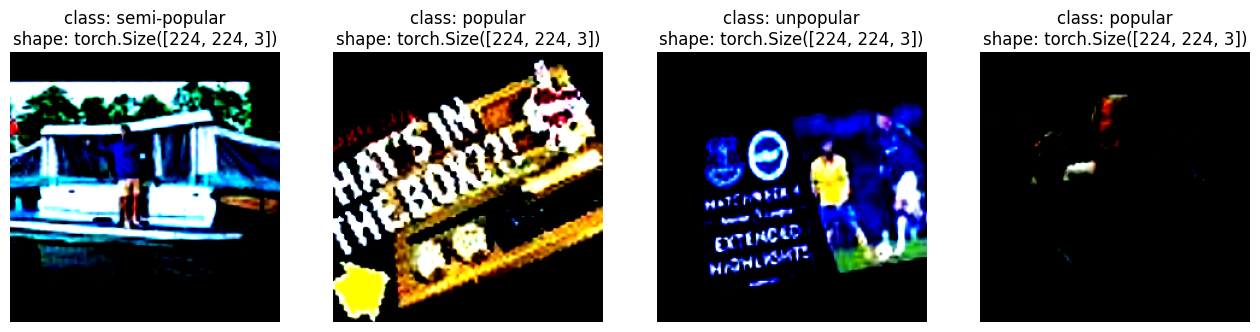

In [8]:
display_random_images(train_dataset, 
                      n=4, 
                      classes=train_dataset.classes,
                      seed=None)

In [6]:
num_workers = os.cpu_count()
batch_size = 32

train_dataloader = DataLoader(
      train_dataset,
      batch_size=batch_size,
      shuffle=True,
      num_workers=num_workers,
      pin_memory=True,
)

test_dataloader = DataLoader(
      test_dataset,
      batch_size=batch_size,
      shuffle=False,
      num_workers=num_workers,
      pin_memory=True,
)

In [7]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [8]:
weights = ResNet50_Weights.IMAGENET1K_V2
model = resnet50(weights=weights).to(device)
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [12]:
summary(model=model, 
        input_size=(32, 3, 224, 224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
ResNet (ResNet)                          [32, 3, 224, 224]    [32, 1000]           --                   True
├─Conv2d (conv1)                         [32, 3, 224, 224]    [32, 64, 112, 112]   9,408                True
├─BatchNorm2d (bn1)                      [32, 64, 112, 112]   [32, 64, 112, 112]   128                  True
├─ReLU (relu)                            [32, 64, 112, 112]   [32, 64, 112, 112]   --                   --
├─MaxPool2d (maxpool)                    [32, 64, 112, 112]   [32, 64, 56, 56]     --                   --
├─Sequential (layer1)                    [32, 64, 56, 56]     [32, 256, 56, 56]    --                   True
│    └─Bottleneck (0)                    [32, 64, 56, 56]     [32, 256, 56, 56]    --                   True
│    │    └─Conv2d (conv1)               [32, 64, 56, 56]     [32, 64, 56, 56]     4,096                True
│    │    └─BatchN

In [9]:
i = 0
for param in model.parameters():
    if i >= 150:
        continue
    param.requires_grad = False
    i+=1

In [10]:
model.fc = nn.Linear(in_features=2048, out_features=len(train_dataset.classes), bias=True)
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [11]:
summary(model=model, 
        input_size=(32, 3, 224, 224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
ResNet (ResNet)                          [32, 3, 224, 224]    [32, 4]              --                   Partial
├─Conv2d (conv1)                         [32, 3, 224, 224]    [32, 64, 112, 112]   (9,408)              False
├─BatchNorm2d (bn1)                      [32, 64, 112, 112]   [32, 64, 112, 112]   (128)                False
├─ReLU (relu)                            [32, 64, 112, 112]   [32, 64, 112, 112]   --                   --
├─MaxPool2d (maxpool)                    [32, 64, 112, 112]   [32, 64, 56, 56]     --                   --
├─Sequential (layer1)                    [32, 64, 56, 56]     [32, 256, 56, 56]    --                   False
│    └─Bottleneck (0)                    [32, 64, 56, 56]     [32, 256, 56, 56]    --                   False
│    │    └─Conv2d (conv1)               [32, 64, 56, 56]     [32, 64, 56, 56]     (4,096)              False
│    │    

In [12]:
loss_fn = nn.CrossEntropyLoss(weight=torch.FloatTensor([4.5351, 3.9330, 3.7697, 3.8467]).to(device))
optimizer = torch.optim.Adam(model.parameters(), lr=0.00001)

In [13]:
def train_step(model: torch.nn.Module, 
               dataloader: DataLoader, 
               loss_fn: torch.nn.Module, 
               optimizer: torch.optim.Optimizer,
               device: torch.device):
  model.train()
  train_acc, train_loss = 0, 0
  true_values = []
  predicted_values = []

  for batch, (X, y) in enumerate(dataloader):
      X, y = X.to(device), y.to(device)
      
      y_pred = model(X)
      loss = loss_fn(y_pred, y)
      train_loss += loss.item() 
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
      predicted_values.extend(y_pred_class.cpu().numpy())
      true_values.extend(y.cpu().numpy())
      train_acc += (y_pred_class == y).sum().item()/len(y_pred)


  print(classification_report(y_true=true_values, y_pred=predicted_values, target_names=train_dataset.classes))
  report = classification_report(y_true=true_values, y_pred=predicted_values, target_names=train_dataset.classes, output_dict=True)
  dataloader_length = len(dataloader)

  train_loss = train_loss / dataloader_length
  train_acc = train_acc / dataloader_length
  return train_loss, train_acc, report

def test_step(model: torch.nn.Module, 
              dataloader: torch.utils.data.DataLoader, 
              loss_fn: torch.nn.Module,
              device: torch.device):
  model.eval() 

  test_acc, test_loss = 0, 0
  true_values = []
  predicted_values = []

  with torch.inference_mode():
      for batch, (X, y) in enumerate(dataloader):
          X, y = X.to(device), y.to(device)
          test_pred_logits = model(X)
          loss = loss_fn(test_pred_logits, y)
          test_loss += loss.item()

          test_pred_labels = test_pred_logits.argmax(dim=1)
          predicted_values.extend(test_pred_labels.cpu().numpy())
          true_values.extend(y.cpu().numpy())
          test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))

  print(classification_report(y_true=true_values, y_pred=predicted_values, target_names=train_dataset.classes))
  report = classification_report(y_true=true_values, y_pred=predicted_values, target_names=train_dataset.classes, output_dict=True)
  dataloader_length = len(dataloader)

  test_loss = test_loss / dataloader_length
  test_acc = test_acc / dataloader_length
  return test_loss, test_acc, report

def train(model: torch.nn.Module, 
          train_dataloader: DataLoader, 
          test_dataloader: DataLoader, 
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module,
          epochs: int,
          device: torch.device):
  results = {"train_loss": [],
      "train_acc": [],
      "train_reports": [],
      "test_loss": [],
      "test_acc": [],
      "test_reports": []
  }

  for epoch in tqdm(range(epochs)):
      print("Training:")
      train_loss, train_acc, train_report = train_step(model= model,
                                                dataloader=train_dataloader,
                                                loss_fn=loss_fn,
                                                optimizer=optimizer,
                                                device=device)
      
      print("Testing:")
      test_loss, test_acc, test_report = test_step(model=model,
                                            dataloader=test_dataloader,
                                            loss_fn=loss_fn,
                                            device=device)

      print(
          f"Epoch: {epoch+1} | "
          f"train_loss: {train_loss:.4f} | "
          f"train_acc: {train_acc:.4f} | "
          f"test_loss: {test_loss:.4f} | "
          f"test_acc: {test_acc:.4f} | "
      )

      results["train_loss"].append(train_loss)
      results["train_acc"].append(train_acc)
      results["train_reports"].append(train_report)
      results["test_loss"].append(test_loss)
      results["test_acc"].append(test_acc)
      results["test_reports"].append(test_report)

  return results

In [14]:
results = train(model=model,
                train_dataloader=train_dataloader,
                test_dataloader=test_dataloader,
                optimizer=optimizer,
                loss_fn=loss_fn,
                epochs=12,
                device=device)

  0%|          | 0/12 [00:00<?, ?it/s]

Training:
              precision    recall  f1-score   support

     popular       0.54      0.52      0.53     22978
semi-popular       0.46      0.57      0.51     26504
   unpopular       0.61      0.56      0.58     27808
very-popular       0.54      0.48      0.51     27379

    accuracy                           0.53    104669
   macro avg       0.54      0.53      0.53    104669
weighted avg       0.54      0.53      0.53    104669

Testing:


  8%|▊         | 1/12 [09:46<1:47:32, 586.62s/it]

              precision    recall  f1-score   support

     popular       0.60      0.57      0.58      5806
semi-popular       0.50      0.64      0.56      6686
   unpopular       0.67      0.62      0.65      6820
very-popular       0.62      0.52      0.56      6556

    accuracy                           0.59     25868
   macro avg       0.60      0.59      0.59     25868
weighted avg       0.60      0.59      0.59     25868

Epoch: 1 | train_loss: 1.0820 | train_acc: 0.5325 | test_loss: 0.9519 | test_acc: 0.5873 | 
Training:
              precision    recall  f1-score   support

     popular       0.60      0.60      0.60     22978
semi-popular       0.51      0.63      0.57     26504
   unpopular       0.69      0.63      0.66     27808
very-popular       0.66      0.56      0.61     27379

    accuracy                           0.61    104669
   macro avg       0.62      0.61      0.61    104669
weighted avg       0.62      0.61      0.61    104669

Testing:


 17%|█▋        | 2/12 [19:31<1:37:35, 585.54s/it]

              precision    recall  f1-score   support

     popular       0.60      0.63      0.62      5806
semi-popular       0.51      0.67      0.58      6686
   unpopular       0.70      0.65      0.67      6820
very-popular       0.71      0.51      0.60      6556

    accuracy                           0.62     25868
   macro avg       0.63      0.62      0.62     25868
weighted avg       0.63      0.62      0.62     25868

Epoch: 2 | train_loss: 0.9096 | train_acc: 0.6073 | test_loss: 0.8848 | test_acc: 0.6160 | 
Training:
              precision    recall  f1-score   support

     popular       0.61      0.64      0.62     22978
semi-popular       0.54      0.66      0.59     26504
   unpopular       0.72      0.65      0.68     27808
very-popular       0.70      0.59      0.64     27379

    accuracy                           0.63    104669
   macro avg       0.64      0.63      0.63    104669
weighted avg       0.64      0.63      0.64    104669

Testing:


 25%|██▌       | 3/12 [29:20<1:28:02, 586.96s/it]

              precision    recall  f1-score   support

     popular       0.61      0.64      0.63      5806
semi-popular       0.53      0.67      0.59      6686
   unpopular       0.71      0.67      0.69      6820
very-popular       0.72      0.54      0.62      6556

    accuracy                           0.63     25868
   macro avg       0.64      0.63      0.63     25868
weighted avg       0.64      0.63      0.63     25868

Epoch: 3 | train_loss: 0.8481 | train_acc: 0.6336 | test_loss: 0.8479 | test_acc: 0.6298 | 
Training:
              precision    recall  f1-score   support

     popular       0.62      0.66      0.64     22978
semi-popular       0.55      0.67      0.60     26504
   unpopular       0.74      0.67      0.70     27808
very-popular       0.73      0.60      0.66     27379

    accuracy                           0.65    104669
   macro avg       0.66      0.65      0.65    104669
weighted avg       0.66      0.65      0.65    104669

Testing:


 33%|███▎      | 4/12 [39:21<1:19:00, 592.60s/it]

              precision    recall  f1-score   support

     popular       0.61      0.67      0.64      5806
semi-popular       0.53      0.70      0.60      6686
   unpopular       0.75      0.65      0.70      6820
very-popular       0.75      0.53      0.62      6556

    accuracy                           0.64     25868
   macro avg       0.66      0.64      0.64     25868
weighted avg       0.66      0.64      0.64     25868

Epoch: 4 | train_loss: 0.8088 | train_acc: 0.6502 | test_loss: 0.8311 | test_acc: 0.6388 | 
Training:
              precision    recall  f1-score   support

     popular       0.63      0.68      0.65     22978
semi-popular       0.57      0.68      0.62     26504
   unpopular       0.75      0.67      0.71     27808
very-popular       0.75      0.62      0.68     27379

    accuracy                           0.66    104669
   macro avg       0.67      0.66      0.66    104669
weighted avg       0.68      0.66      0.67    104669

Testing:


 42%|████▏     | 5/12 [49:08<1:08:54, 590.65s/it]

              precision    recall  f1-score   support

     popular       0.60      0.69      0.64      5806
semi-popular       0.54      0.69      0.61      6686
   unpopular       0.76      0.64      0.70      6820
very-popular       0.76      0.56      0.64      6556

    accuracy                           0.65     25868
   macro avg       0.66      0.65      0.65     25868
weighted avg       0.67      0.65      0.65     25868

Epoch: 5 | train_loss: 0.7805 | train_acc: 0.6634 | test_loss: 0.8218 | test_acc: 0.6448 | 
Training:
              precision    recall  f1-score   support

     popular       0.64      0.70      0.67     22978
semi-popular       0.58      0.69      0.63     26504
   unpopular       0.76      0.69      0.72     27808
very-popular       0.76      0.63      0.69     27379

    accuracy                           0.68    104669
   macro avg       0.68      0.68      0.68    104669
weighted avg       0.69      0.68      0.68    104669

Testing:


 50%|█████     | 6/12 [56:51<54:43, 547.24s/it]  

              precision    recall  f1-score   support

     popular       0.62      0.67      0.65      5806
semi-popular       0.54      0.70      0.61      6686
   unpopular       0.75      0.67      0.71      6820
very-popular       0.76      0.57      0.65      6556

    accuracy                           0.65     25868
   macro avg       0.67      0.65      0.65     25868
weighted avg       0.67      0.65      0.65     25868

Epoch: 6 | train_loss: 0.7540 | train_acc: 0.6759 | test_loss: 0.8077 | test_acc: 0.6514 | 
Training:
              precision    recall  f1-score   support

     popular       0.65      0.71      0.68     22978
semi-popular       0.59      0.70      0.64     26504
   unpopular       0.77      0.70      0.73     27808
very-popular       0.77      0.65      0.71     27379

    accuracy                           0.69    104669
   macro avg       0.70      0.69      0.69    104669
weighted avg       0.70      0.69      0.69    104669

Testing:


 58%|█████▊    | 7/12 [1:04:22<42:58, 515.63s/it]

              precision    recall  f1-score   support

     popular       0.63      0.68      0.65      5806
semi-popular       0.55      0.68      0.61      6686
   unpopular       0.74      0.69      0.71      6820
very-popular       0.74      0.58      0.65      6556

    accuracy                           0.65     25868
   macro avg       0.67      0.66      0.66     25868
weighted avg       0.67      0.65      0.66     25868

Epoch: 7 | train_loss: 0.7292 | train_acc: 0.6884 | test_loss: 0.8024 | test_acc: 0.6545 | 
Training:
              precision    recall  f1-score   support

     popular       0.66      0.72      0.69     22978
semi-popular       0.61      0.71      0.65     26504
   unpopular       0.78      0.71      0.74     27808
very-popular       0.78      0.66      0.72     27379

    accuracy                           0.70    104669
   macro avg       0.71      0.70      0.70    104669
weighted avg       0.71      0.70      0.70    104669

Testing:


 67%|██████▋   | 8/12 [1:11:51<32:58, 494.72s/it]

              precision    recall  f1-score   support

     popular       0.63      0.66      0.65      5806
semi-popular       0.54      0.73      0.62      6686
   unpopular       0.76      0.66      0.71      6820
very-popular       0.76      0.57      0.65      6556

    accuracy                           0.66     25868
   macro avg       0.67      0.66      0.66     25868
weighted avg       0.68      0.66      0.66     25868

Epoch: 8 | train_loss: 0.7044 | train_acc: 0.6990 | test_loss: 0.8037 | test_acc: 0.6555 | 
Training:
              precision    recall  f1-score   support

     popular       0.67      0.73      0.70     22978
semi-popular       0.62      0.71      0.66     26504
   unpopular       0.78      0.72      0.75     27808
very-popular       0.79      0.68      0.73     27379

    accuracy                           0.71    104669
   macro avg       0.72      0.71      0.71    104669
weighted avg       0.72      0.71      0.71    104669

Testing:


 75%|███████▌  | 9/12 [1:19:21<24:02, 480.73s/it]

              precision    recall  f1-score   support

     popular       0.64      0.66      0.65      5806
semi-popular       0.55      0.69      0.61      6686
   unpopular       0.73      0.69      0.71      6820
very-popular       0.75      0.58      0.65      6556

    accuracy                           0.66     25868
   macro avg       0.67      0.66      0.66     25868
weighted avg       0.67      0.66      0.66     25868

Epoch: 9 | train_loss: 0.6801 | train_acc: 0.7092 | test_loss: 0.7993 | test_acc: 0.6550 | 
Training:
              precision    recall  f1-score   support

     popular       0.68      0.74      0.71     22978
semi-popular       0.63      0.72      0.67     26504
   unpopular       0.79      0.73      0.76     27808
very-popular       0.80      0.69      0.74     27379

    accuracy                           0.72    104669
   macro avg       0.73      0.72      0.72    104669
weighted avg       0.73      0.72      0.72    104669

Testing:


 83%|████████▎ | 10/12 [1:26:52<15:42, 471.43s/it]

              precision    recall  f1-score   support

     popular       0.64      0.66      0.65      5806
semi-popular       0.56      0.67      0.61      6686
   unpopular       0.73      0.69      0.71      6820
very-popular       0.72      0.60      0.66      6556

    accuracy                           0.66     25868
   macro avg       0.66      0.66      0.66     25868
weighted avg       0.66      0.66      0.66     25868

Epoch: 10 | train_loss: 0.6580 | train_acc: 0.7195 | test_loss: 0.8006 | test_acc: 0.6551 | 
Training:
              precision    recall  f1-score   support

     popular       0.69      0.76      0.72     22978
semi-popular       0.64      0.73      0.68     26504
   unpopular       0.80      0.74      0.77     27808
very-popular       0.81      0.71      0.75     27379

    accuracy                           0.73    104669
   macro avg       0.74      0.73      0.73    104669
weighted avg       0.74      0.73      0.73    104669

Testing:


 92%|█████████▏| 11/12 [1:34:22<07:45, 465.00s/it]

              precision    recall  f1-score   support

     popular       0.63      0.69      0.66      5806
semi-popular       0.56      0.68      0.61      6686
   unpopular       0.74      0.68      0.71      6820
very-popular       0.75      0.57      0.65      6556

    accuracy                           0.66     25868
   macro avg       0.67      0.66      0.66     25868
weighted avg       0.67      0.66      0.66     25868

Epoch: 11 | train_loss: 0.6367 | train_acc: 0.7308 | test_loss: 0.8087 | test_acc: 0.6556 | 
Training:
              precision    recall  f1-score   support

     popular       0.70      0.77      0.73     22978
semi-popular       0.65      0.74      0.69     26504
   unpopular       0.80      0.74      0.77     27808
very-popular       0.82      0.72      0.76     27379

    accuracy                           0.74    104669
   macro avg       0.74      0.74      0.74    104669
weighted avg       0.75      0.74      0.74    104669

Testing:


100%|██████████| 12/12 [1:41:53<00:00, 509.45s/it]

              precision    recall  f1-score   support

     popular       0.61      0.71      0.65      5806
semi-popular       0.58      0.64      0.60      6686
   unpopular       0.74      0.68      0.71      6820
very-popular       0.73      0.60      0.66      6556

    accuracy                           0.66     25868
   macro avg       0.66      0.66      0.66     25868
weighted avg       0.66      0.66      0.66     25868

Epoch: 12 | train_loss: 0.6134 | train_acc: 0.7401 | test_loss: 0.8132 | test_acc: 0.6551 | 


In [15]:
def get_metrics(results, report_type, class_name, metric_name):
    metrics = []
    for report in results[report_type]:
        metrics.append(report[class_name][metric_name])
    return metrics

def plot_results(results):
    loss = results['train_loss']
    test_loss = results['test_loss']

    accuracy = results['train_acc']
    test_accuracy = results['test_acc']

    popular_train_recall = get_metrics(results, "train_reports", "popular", "recall")
    popular_train_precision = get_metrics(results, "train_reports", "popular", "precision")
    popular_train_f1 = get_metrics(results, "train_reports", "popular", "f1-score")
    popular_test_recall = get_metrics(results, "test_reports", "popular", "recall")
    popular_test_precision = get_metrics(results, "test_reports", "popular", "precision")
    popular_test_f1 = get_metrics(results, "test_reports", "popular", "f1-score")

    unpopular_train_recall = get_metrics(results, "train_reports", "unpopular", "recall")
    unpopular_train_precision = get_metrics(results, "train_reports", "unpopular", "precision")
    unpopular_train_f1 = get_metrics(results, "train_reports", "unpopular", "f1-score")
    unpopular_test_recall = get_metrics(results, "test_reports", "unpopular", "recall")
    unpopular_test_precision = get_metrics(results, "test_reports", "unpopular", "precision")
    unpopular_test_f1 = get_metrics(results, "test_reports", "unpopular", "f1-score")

    semi_popular_train_recall = get_metrics(results, "train_reports", "semi-popular", "recall")
    semi_popular_train_precision = get_metrics(results, "train_reports", "semi-popular", "precision")
    semi_popular_train_f1 = get_metrics(results, "train_reports", "semi-popular", "f1-score")
    semi_popular_test_recall = get_metrics(results, "test_reports", "semi-popular", "recall")
    semi_popular_test_precision = get_metrics(results, "test_reports", "semi-popular", "precision")
    semi_popular_test_f1 = get_metrics(results, "test_reports", "semi-popular", "f1-score")

    very_popular_train_recall = get_metrics(results, "train_reports", "very-popular", "recall")
    very_popular_train_precision = get_metrics(results, "train_reports", "very-popular", "precision")
    very_popular_train_f1 = get_metrics(results, "train_reports", "very-popular", "f1-score")
    very_popular_test_recall = get_metrics(results, "test_reports", "very-popular", "recall")
    very_popular_test_precision = get_metrics(results, "test_reports", "very-popular", "precision")
    very_popular_test_f1 = get_metrics(results, "test_reports", "very-popular", "f1-score")

    epochs = range(len(results['train_loss']))

    plt.figure(figsize=(15, 7))
    plt.subplots_adjust(left=0.1,
                        bottom=0.1, 
                        right=0.9, 
                        top=3, 
                        wspace=0.4, 
                        hspace=0.4)

    plt.subplot(6, 1, 1)
    plt.plot(epochs, loss, label='train_loss')
    plt.plot(epochs, test_loss, label='test_loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.legend()

    plt.subplot(6, 1, 2)
    plt.plot(epochs, accuracy, label='train_accuracy')
    plt.plot(epochs, test_accuracy, label='test_accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.legend()

    plt.subplot(6, 1, 3)
    plt.plot(epochs, popular_train_recall, label='popular_train_recall')
    plt.plot(epochs, popular_train_precision, label='popular_train_precision')
    plt.plot(epochs, popular_train_f1, label='popular_train_f1')
    plt.plot(epochs, popular_test_recall, label='popular_test_recall')
    plt.plot(epochs, popular_test_precision, label='popular_test_precision')
    plt.plot(epochs, popular_test_f1, label='popular_test_f1')
    plt.title('Popular')
    plt.xlabel('Epochs')
    plt.legend()

    plt.subplot(6, 1, 4)
    plt.plot(epochs, unpopular_train_recall, label='unpopular_train_recall')
    plt.plot(epochs, unpopular_train_precision, label='unpopular_train_precision')
    plt.plot(epochs, unpopular_train_f1, label='unpopular_train_f1')
    plt.plot(epochs, unpopular_test_recall, label='unpopular_test_recall')
    plt.plot(epochs, unpopular_test_precision, label='unpopular_test_precision')
    plt.plot(epochs, unpopular_test_f1, label='unpopular_test_f1')
    plt.title('Unpopular')
    plt.xlabel('Epochs')
    plt.legend()

    plt.subplot(6, 1, 5)
    plt.plot(epochs, semi_popular_train_recall, label='semi_popular_train_recall')
    plt.plot(epochs, semi_popular_train_precision, label='semi_popular_train_precision')
    plt.plot(epochs, semi_popular_train_f1, label='semi_popular_train_f1')
    plt.plot(epochs, semi_popular_test_recall, label='semi_popular_test_recall')
    plt.plot(epochs, semi_popular_test_precision, label='semi_popular_test_precision')
    plt.plot(epochs, semi_popular_test_f1, label='semi_popular_test_f1')
    plt.title('Semi-popular')
    plt.xlabel('Epochs')
    plt.legend()

    plt.subplot(6, 1, 6)
    plt.plot(epochs, very_popular_train_recall, label='very-popular_train_recall')
    plt.plot(epochs, very_popular_train_precision, label='very-popular_train_precision')
    plt.plot(epochs, very_popular_train_f1, label='very-popular_train_f1')
    plt.plot(epochs, very_popular_test_recall, label='very-popular_test_recall')
    plt.plot(epochs, very_popular_test_precision, label='very-popular_test_precision')
    plt.plot(epochs, very_popular_test_f1, label='very-popular_test_f1')
    plt.title('Very-popular')
    plt.xlabel('Epochs')
    plt.legend()

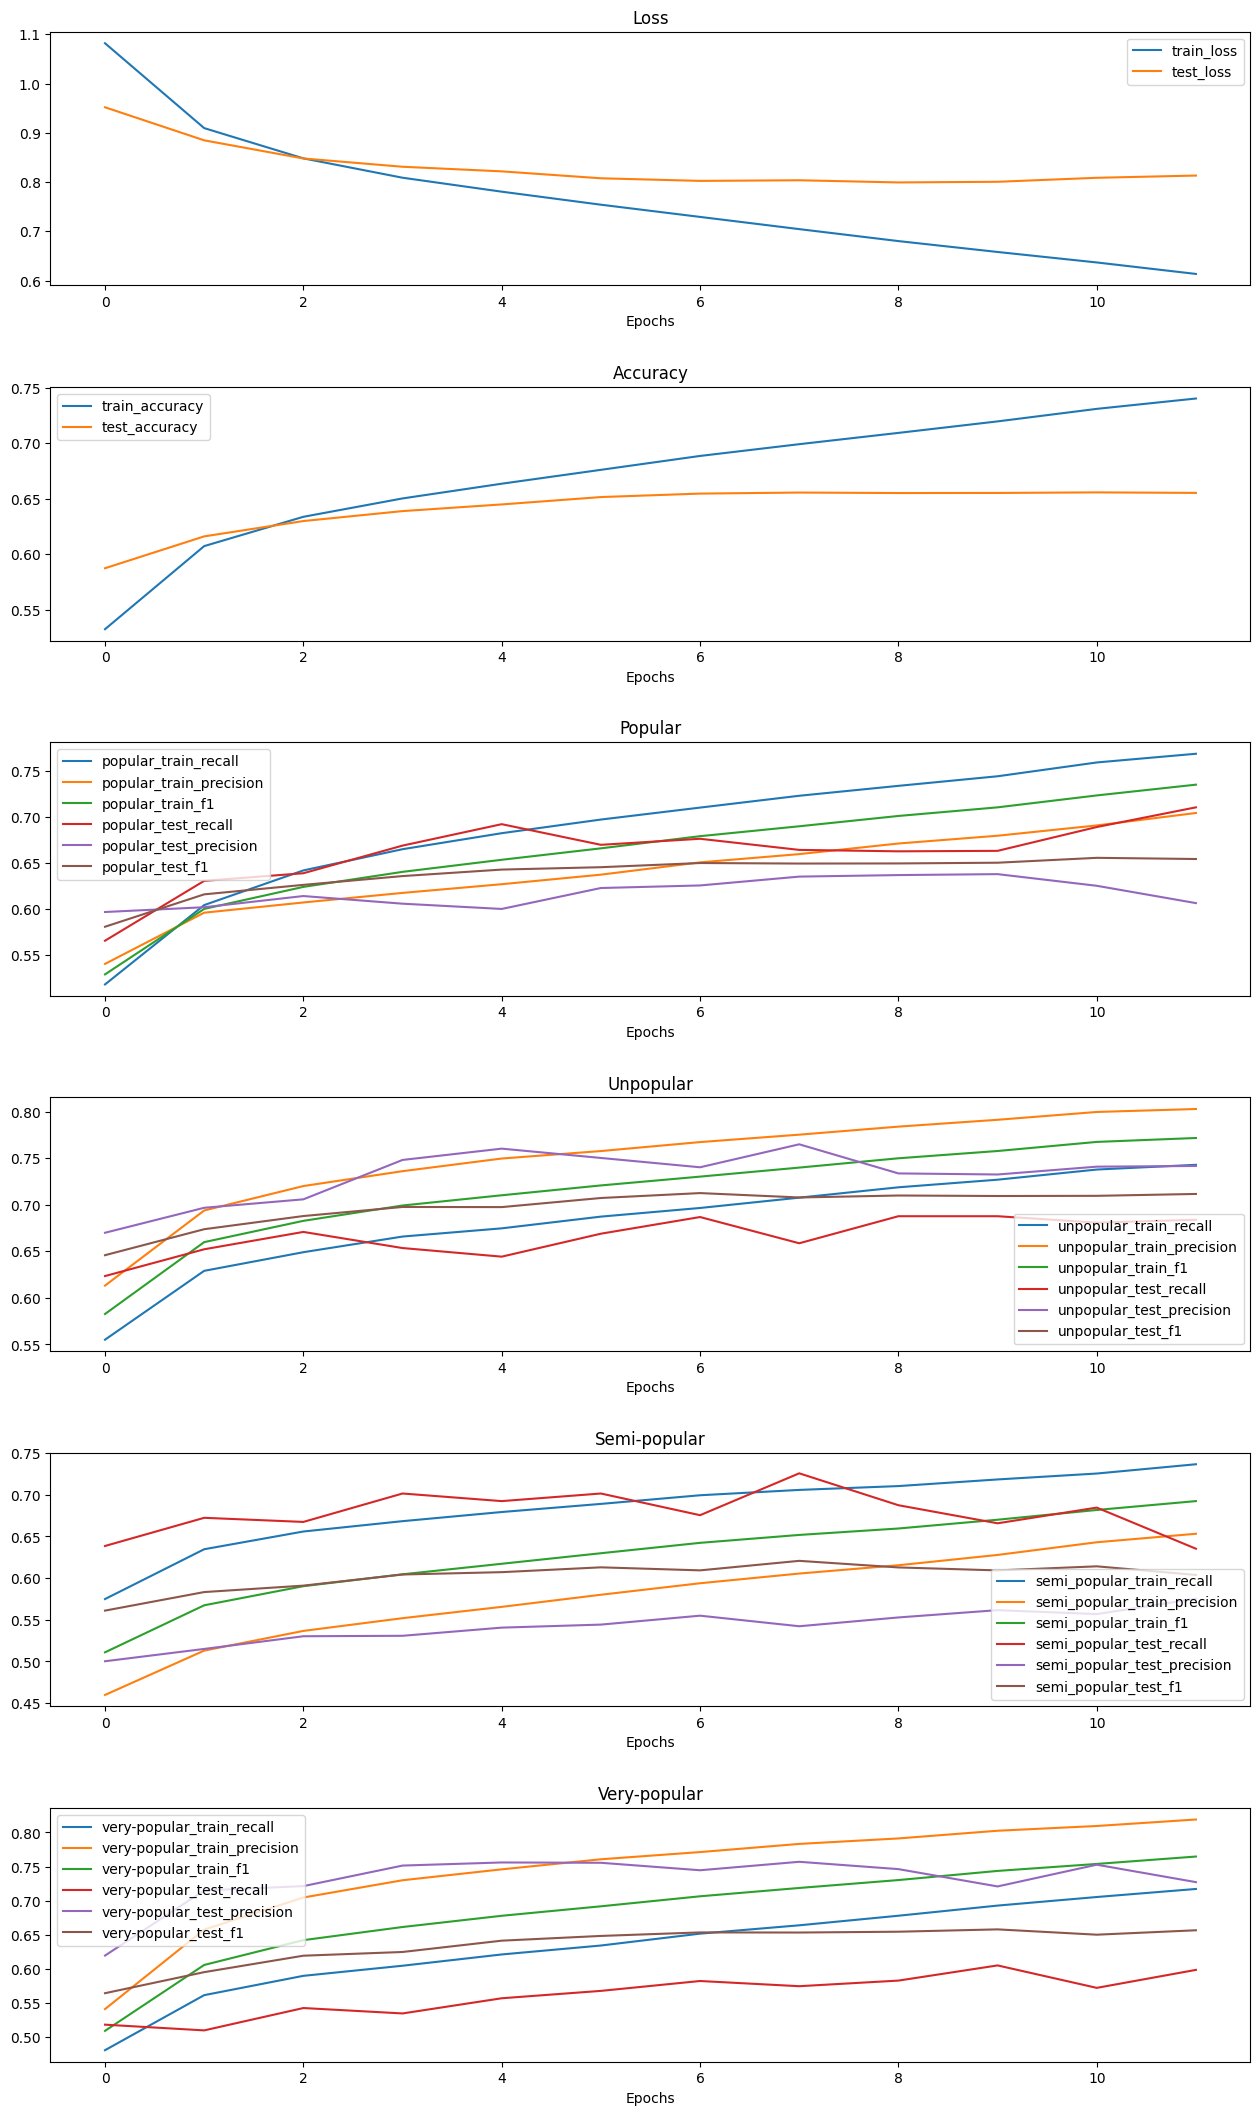

In [16]:
plot_results(results)

In [20]:
MODEL_PATH = Path("../models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

In [21]:
MODEL_NAME = "image_classifier.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

In [22]:
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=model.state_dict(),
           f=MODEL_SAVE_PATH)

Saving model to: ..\models\image_classifier.pth


In [23]:
loaded_model = resnet50().to(device)
loaded_model.fc = nn.Linear(in_features=2048, out_features=len(train_dataset.classes), bias=True)
loaded_model.load_state_dict(torch.load(f=MODEL_SAVE_PATH))
loaded_model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [24]:
def pred_and_plot_image(model: torch.nn.Module,
                        image_path: str, 
                        class_names,
                        device: torch.device=device):
    
    img = Image.open(image_path)
    image_transform = ResNet50_Weights.IMAGENET1K_V2.transforms()
    model.to(device)
    model.eval()

    with torch.inference_mode():
      transformed_image = image_transform(img).unsqueeze(dim=0)
      target_image_pred = model(transformed_image.to(device))

    target_image_pred_probs = torch.softmax(target_image_pred, dim=1)
    print(target_image_pred_probs)

    target_image_pred_label = torch.argmax(target_image_pred_probs, dim=1)
    print(target_image_pred_label)
    print(class_names)

    plt.figure()
    plt.imshow(img)
    plt.title(f"Pred: {class_names[target_image_pred_label]} | Prob: {target_image_pred_probs.max():.3f}")
    plt.axis(False);

tensor([[8.3139e-01, 1.6243e-01, 5.9322e-03, 2.4998e-04]], device='cuda:0')
tensor([0], device='cuda:0')
['popular', 'semi-popular', 'unpopular', 'very-popular']


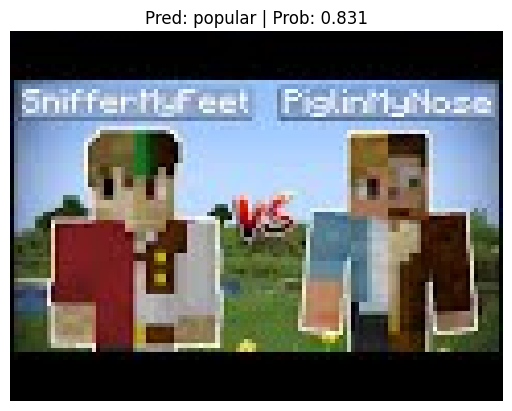

In [25]:
pred_and_plot_image(model=loaded_model, 
                    image_path="../data/images/train/popular/1WVRmKcjCOM.jpg",
                    class_names=train_dataset.classes)